In [1]:
import xgboost as xgb
import pickle
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import json
import seaborn as sns
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from helper import extract_data, create_features, sorted_correlations_with_gold, \
                    remove_correlated_features, create_lr_plot, create_xgb_plot
%matplotlib inline

# Problem Statement

**predicing the price of gold at market close on Friday July 24th.**

The goal of this exercise is to forecast the price of gold for few days ahead. In theory, there are many factors and so many ever-changing variables are involved in determining the prices in the free market. Therefore, forecasting these variables accurately would not be possible. However statistical and machine learning methods are able to learn from the patterns in historical data. By considering different factors and learning the trends in the past, we might be able to make better than random guesses in the future.

We formulate our problem as regressing the value (y2/y1)-1 at **N** days ahead. N can be any arbitrary number but for this problem we set N=3 to forecast the price of gold on July 20th for Friday July 20th. For our modeling pipeline we follow classic ML workflow containing data extraction, preprocessing, feature engineering, model training, evaluation and hyper parameter tuning. All these steps are explained in this notebook in detail.


![workflow](https://miro.medium.com/max/1400/1*ioZ200iYyX-QJfOLs17gow.jpeg)

# Data Collection

In addition to historical price of gold, many external factors can affect the price. Changes in the price of other commodities and metals, stock market indexes, exchange rates and other financial indexes may have correlation with the price of gold which can help us in forecasting the target variable. We use an exhaustive and greedy approach in collecting different indicators and in the feature engineering step we discard the features that are not helpful in the model. We consider the following indicators and extract the daily closing prices from YahooFinancials API for the past 10 years:

* Gold
* Silver 
* Crude Oil
* Platinium
* Copper
* S&P500 (stock trade)
* Euronext 100 (stock trade: Euro)
* MSCI EM ETF (stock trade: emerging markets)
* US 2 Year T-Note Futures
* US 10 Year T-Note Futures
* Dollar Index
* EuroUSD (exchange rate)
* Vix: Volatility Index

 

In [8]:
start_date = '2010-07-15'
end_date= '2020-07-22'
n_days_ahead = 3

In [3]:
with open("tickers.json", "r") as f:
    tickers = json.loads(f.read())

In the extracted dataset missing values exists for weekends and public holidays. One approach can be removing these values, but in order to keep the continuity of the data in timeseries format we perform backfilling on the data so that these Null values get the next non-null value in the series. We also convert all the values into numeric values with 2 decimal points to standardise them.

In [4]:
values = extract_data(start_date, end_date, tickers)
values.tail()

date    Gold  Silver  Crude Oil   S&P500  10 Yr US T-Note futures  \
3655 2020-07-17  1812.1   19.75      40.57  3224.73                   139.36   
3656 2020-07-18  1812.1   19.75      40.57  3224.73                   139.36   
3657 2020-07-19  1810.5   19.75      40.63  3224.73                   139.34   
3658 2020-07-20  1819.6   20.36      40.65  3251.84                   139.42   
3659 2020-07-21  1828.6   20.95      42.16  3264.80                   139.38   

      2 Yr US T-Note Futures  Platinum  Copper  Dollar Index  \
3655                  110.41     851.4    2.90         96.07   
3656                  110.41     851.4    2.90         96.07   
3657                  110.41     851.2    2.91         96.07   
3658                  110.42     862.6    2.93         96.07   
3659                  110.41     877.8    2.94         95.48   

      Volatility Index  MSCI EM ETF  Euro USD  Euronext100  
3655             25.68        42.77      1.14      1006.22  
3656             25.68        42.77      1.14      1006.22  
3657             25.68        42.77      1.14      1006.22  
3658             24.46        43.32      1.14      1012.81  
3659             24.08        43.84      1.15      1019.34

In [5]:
values.shape

(3660, 14)

# Exploratory Data Analysis

Lets look at the statistical properties of each indicator and visualize their normalized values to get a better sense of the data.

In [6]:
values.describe()

Gold       Silver    Crude Oil       S&P500  \
count  3660.000000  3660.000000  3660.000000  3660.000000   
mean   1374.775492    21.055637    70.274691  2065.234514   
std     188.363324     7.091576    23.381260   602.854892   
min    1050.800000    11.770000    -2.720000  1047.220000   
25%    1237.800000    16.220000    50.350000  1472.285000   
50%    1311.600000    17.770000    64.975000  2053.420000   
75%    1508.925000    23.935000    93.452500  2599.950000   
max    1888.700000    48.580000   113.930000  3386.150000   

       10 Yr US T-Note futures  2 Yr US T-Note Futures     Platinum  \
count              3660.000000             3660.000000  3660.000000   
mean                127.254768              108.953686  1209.481311   
std                   4.615803                1.439380   329.839879   
min                 117.500000              105.160000   596.800000   
25%                 124.440000              108.157500   922.750000   
50%                 126.750000              109.560000  1094.700000   
75%                 130.560000              110.120000  1495.425000   
max                 139.500000              110.420000  1905.700000   

            Copper  Dollar Index  Volatility Index  MSCI EM ETF     Euro USD  \
count  3660.000000   3660.000000       3660.000000  3660.000000  3660.000000   
mean      3.028440     89.205413         17.278402    36.828833     1.219232   
std       0.579688      8.422750          7.220199     4.173138     0.113321   
min       1.940000     73.110000          9.140000    25.690000     1.040000   
25%       2.620000     80.600000         12.920000    34.010000     1.120000   
50%       3.010000     92.880000         15.320000    36.535000     1.180000   
75%       3.370000     96.780000         18.940000    39.520000     1.320000   
max       4.620000    103.610000         82.690000    49.250000     1.480000   

       Euronext100  
count  3660.000000  
mean    860.278634  
std     159.315736  
min     529.500000  
25%     713.900000  
50%     864.180000  
75%     999.895000  
max    1182.100000

We can see the trend of each indicator (normalized) over the past 10 years and compare them with the trend of the gold price. For instance price of silver shows similar pattern to the price of gold over the years which can be helpful in the modeling.

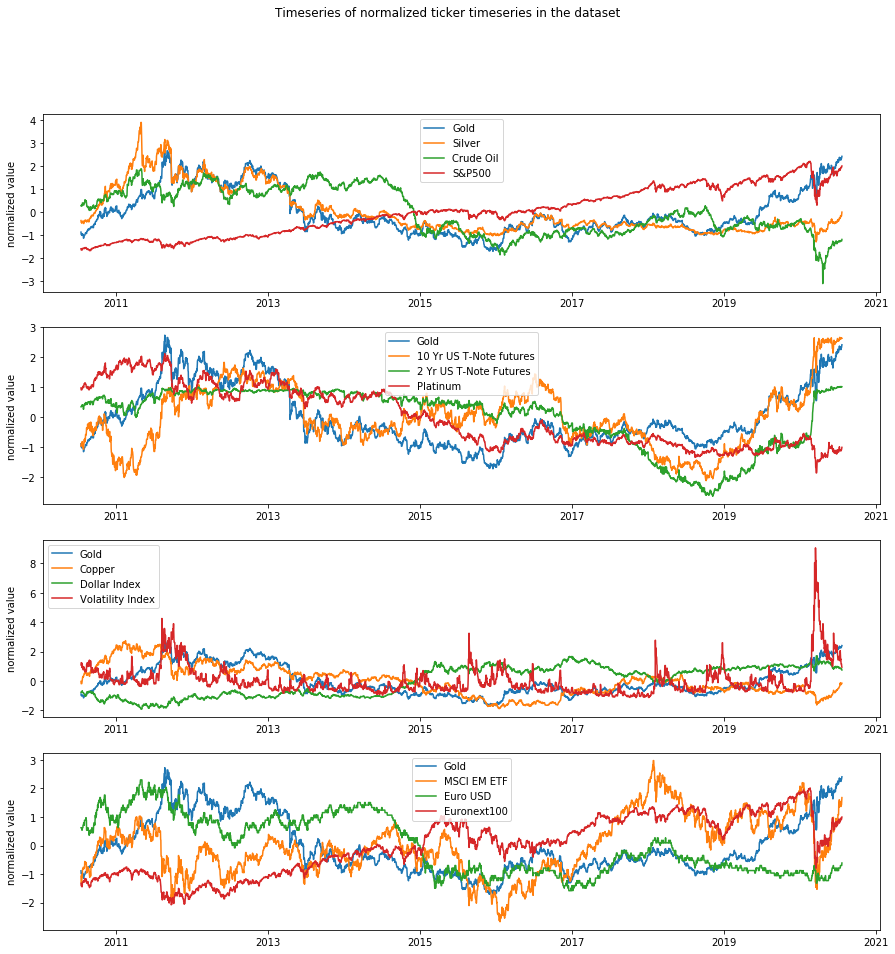

In [7]:
f, axes = plt.subplots(4, 1, figsize=(15,15))
f.suptitle("Timeseries of normalized ticker timeseries in the dataset")
for i in range(4):
    axes[i].plot(values['date'],(values['Gold']-np.mean(values['Gold']))/np.std(values['Gold']), label = 'Gold')
    for x in list(tickers.keys())[i*3+1:(i+1)*3+1]:
        axes[i].plot(values['date'],(values[x]-np.mean(values[x]))/np.std(values[x]), label = x)
    axes[i].legend()
    axes[i].set_ylabel("normalized value")

Histogram of the gold prices over the past 10 years show a bimodal pattern with 2 peaks one around 1300 USD and one around 1700 USD. skewness value shows that the data is moderately skewed.

/Users/ali.zonoozi/anaconda3/envs/scotia/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Skewness: 0.738344
Kurtosis: -0.550697


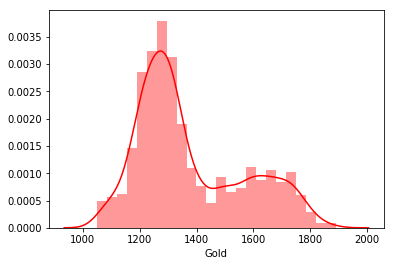

In [9]:
sns.distplot(values['Gold'], color = 'red')
print('Skewness: %f' %values['Gold'].skew())
print("Kurtosis: %f" % values['Gold'].kurt())

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fe3cb00>,
      dtype=object)

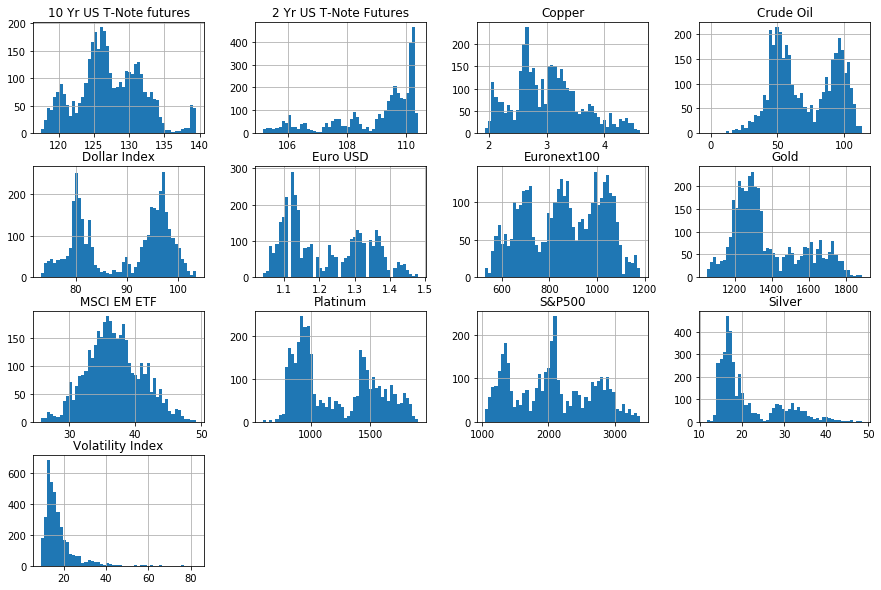

In [10]:
values.hist(bins=50, figsize=(15, 10))


## Correlation Analysis

Looking at the pair scatter plots gives us better understanding of correlations among different features. It is visible that some indicators are highly correlated (e.g. Dollar Index & EuroUSD) and including them in the model would hurt the model performance. So one of the highly correlated features need to be removed from the candidate features set.

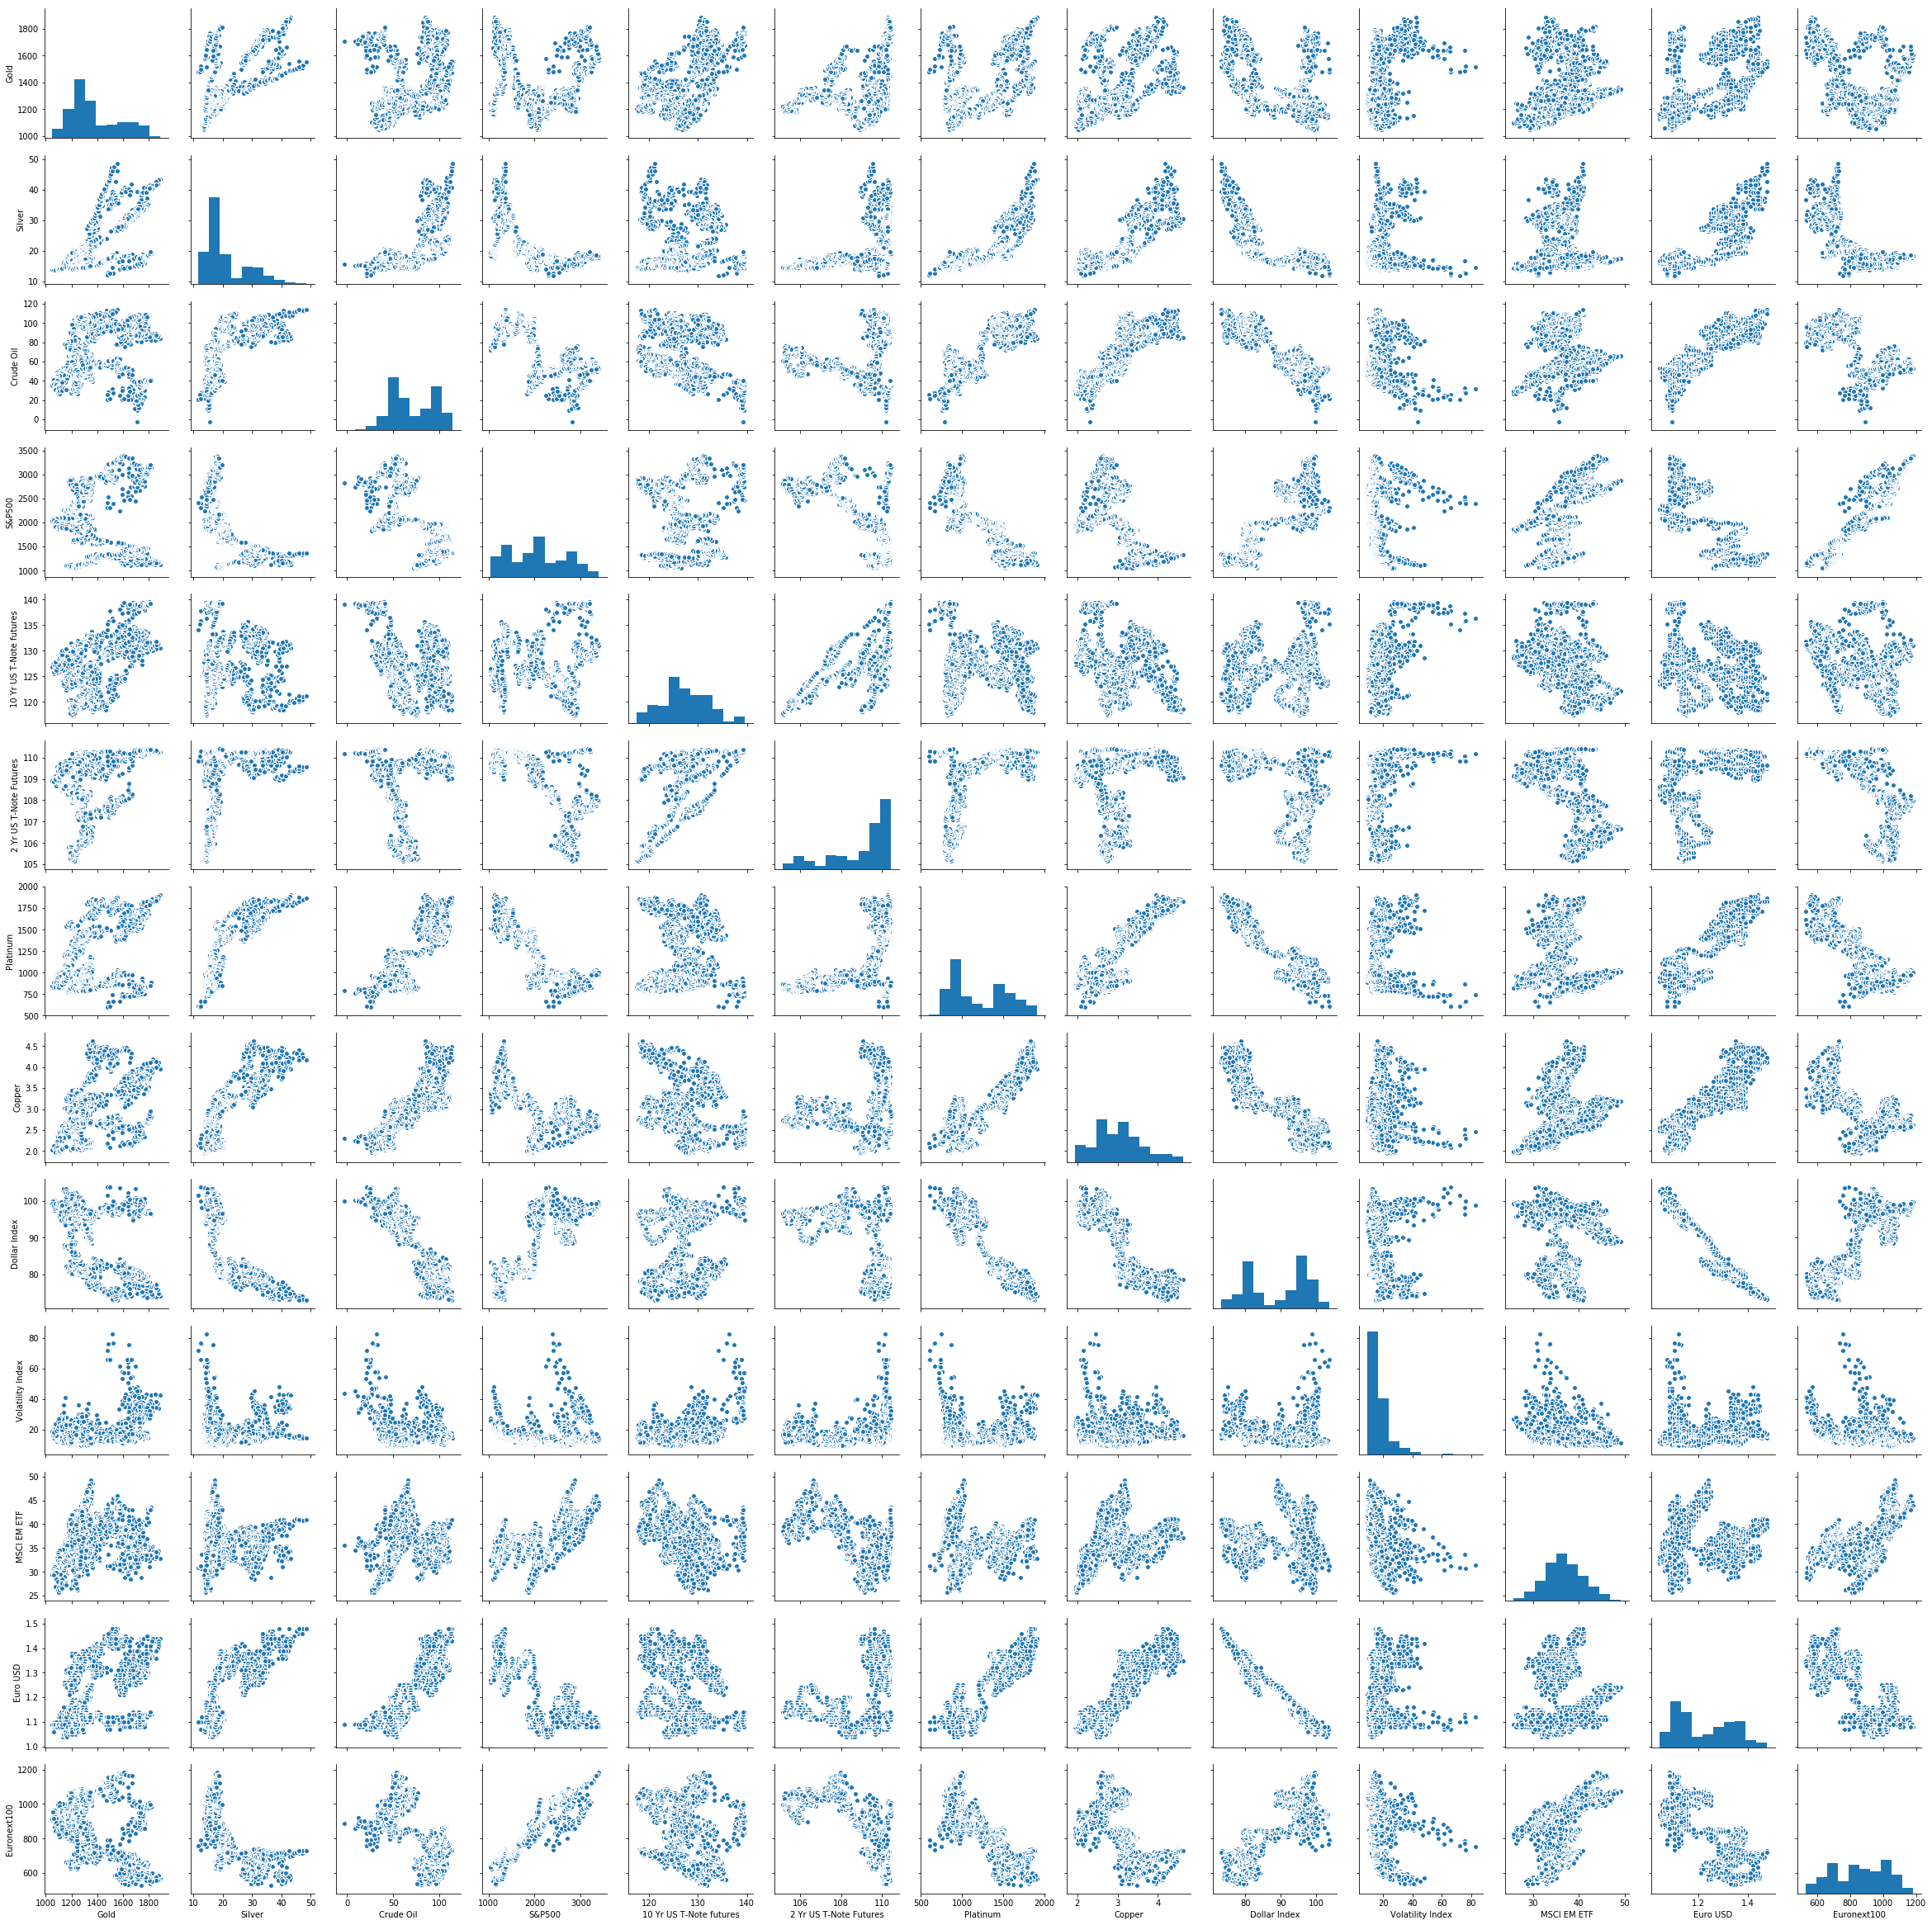

In [12]:
sns.pairplot(values.loc[:,values.dtypes == 'float64'])

The following heatmap plots provide the same information in a quantified fashion. We can see that and indicator such as Silver has correlation of 0.71 with the gold price, while MSCI EM has a low correlation.

Text(0.5,1.05,'Correlation of Features')

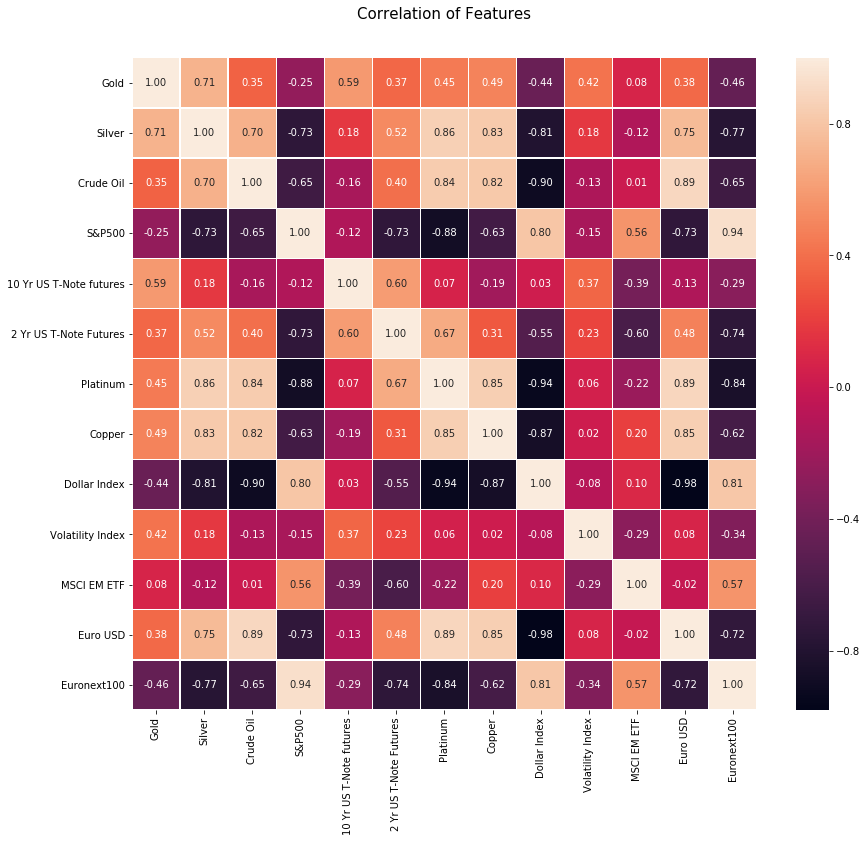

In [11]:
corr = values.corr()
plt.figure(figsize = (14,12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,fmt='.2f',linewidths=0.30)
plt.title('Correlation of Features', y = 1.05, size=15)

In this step we remove one of the highly correlated features. A threshold=0.9 is used to identify highly correlated features. Among 2 correlated features the one that has lower absolute correlation with Gold price is removed. In the following plot we can see the correlation heatmap after removing extra features.

corelated features to be removed: {'S&P500', 'Crude Oil', 'Euro USD', 'Dollar Index'}


Text(0.5,1.05,'Correlation of Features')

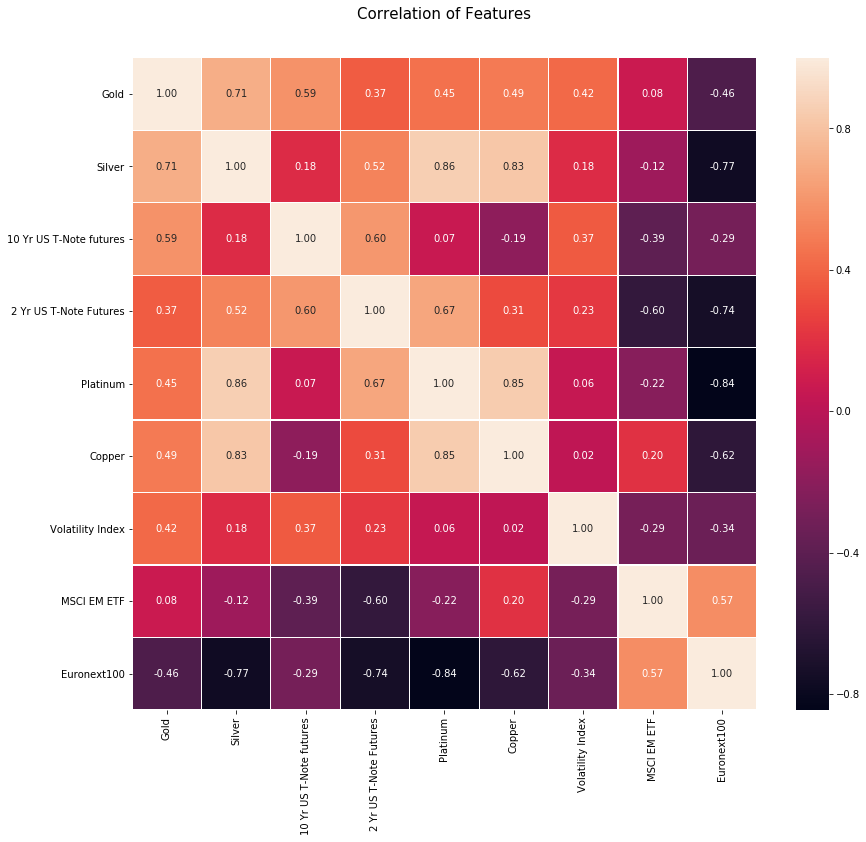

In [12]:
values = remove_correlated_features(values, corr, threshold=0.9)
corr = values.corr()
plt.figure(figsize = (14,12))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,fmt='.2f',linewidths=0.30)
plt.title('Correlation of Features', y = 1.05, size=15)

In [13]:
print(values.shape)
values.head()

(3660, 10)


date    Gold  Silver  10 Yr US T-Note futures  2 Yr US T-Note Futures  \
0 2010-07-15  1208.1   18.35                   122.78                  109.45   
1 2010-07-16  1188.0   17.77                   123.20                  109.47   
2 2010-07-17  1188.0   17.77                   123.20                  109.47   
3 2010-07-18  1188.0   17.77                   123.20                  109.47   
4 2010-07-19  1181.7   17.53                   123.03                  109.47   

   Platinum  Copper  Volatility Index  MSCI EM ETF  Euronext100  
0    1529.9    3.01             25.14        32.36       649.16  
1    1508.4    2.92             26.25        31.39       635.56  
2    1508.4    2.92             26.25        31.39       635.56  
3    1508.4    2.92             26.25        31.39       635.56  
4    1509.4    2.93             25.97        31.81       632.54

# Feature Engineering

The absolute values of price timeseries data are non-stationary and have different scales which are not suitable as features for a model. Next step is to extract meaningful features from these indicators. For this purpose we need to extract different lagged effect to capture short-term and long term effect on the target variable. We are adding 5 types of features to out feature set:

* **Short-Term Rate of Change**: For all the available indicators, we add short-term rate of change with regards to the same date price. The rate of change is defines as $\frac{C(x) - C(x-n)}{C(x-n)}$ where C(x) is price on day x. ROC for lags of [1, 2, 3, 5, 7, 14, 21, 30] days are added to the feature set.
* **Long-Term Rate of Change**: For selected set of indicators with higher correlation with gold price, long term lags are extracted (2,3,6 months) and are added to the feature set.
* **ROC over Moving Average for Gold**: moving average are commonly used in timeseries data as it provides more stable signal changes over a moving window. We also add rate of change using simple moving average (windows of [15, 30, 60, 90, 180] days) and exponential moving average (windows of [30, 60, 90, 180] days) features to our feature set.
* **Stochastic Oscillators**: stochastic Oscillators are indicators of over-bought of oversold stocks or commodities which can indicate a signal for market adjustments in near future. This values is calculated using the formula $ \frac{C(x)-L_n}{H_n-L_n}$ where C(X) is price on day x, $L_n$ is the lowest price over past n days and $H_n$ is the highest prices over past n days. We added this feature for highest correlated features, with n=14 days.
* **Ratio of $ROC_1$/$ROC_n$** As ROC gives us an indication price change going up and down, ratio of ROC can provide information on how the changes in prices are changing (similar to second order derivatives). For this purpose we calculate ratios for the past [2, 3, 5, 7, 14, 21] rate of changes.

Putting all the features togetger would give us 153 features in total. However many of them may not be useful. Using forward selection approach we can filter these features to gather a list of informative features for our model.

In [14]:
features = create_features(values)
features.tail()

date  Gold_t-1  Silver_t-1  10 Yr US T-Note futures_t-1  \
3475 2020-07-17  0.007954    0.011783                    -0.000359   
3476 2020-07-18  0.000000    0.000000                     0.000000   
3477 2020-07-19 -0.000883    0.000000                    -0.000144   
3478 2020-07-20  0.005026    0.030886                     0.000574   
3479 2020-07-21  0.004946    0.028978                    -0.000287   

      2 Yr US T-Note Futures_t-1  Platinum_t-1  Copper_t-1  \
3475                   -0.000091      0.016840    0.006944   
3476                    0.000000      0.000000    0.000000   
3477                    0.000000     -0.000235    0.003448   
3478                    0.000091      0.013393    0.006873   
3479                   -0.000091      0.017621    0.003413   

      Volatility Index_t-1  MSCI EM ETF_t-1  Euronext100_t-1  \
3475             -0.082857         0.005643        -0.002360   
3476              0.000000         0.000000         0.000000   
3477              0.000000         0.000000         0.000000   
3478             -0.047508         0.012859         0.006549   
3479             -0.015536         0.012004         0.006447   

                ...             Platinum_rocr_5  Platinum_rocr_7  \
3475            ...                    2.455133         3.169258   
3476            ...                    0.000000         0.000000   
3477            ...                   -0.029609        -0.035471   
3478            ...                    0.717789         0.678384   
3479            ...                    0.364301         0.446879   

      Platinum_rocr_14  Platinum_rocr_21  Volatility Index_rocr_2  \
3475          0.826539          0.317366                 1.105824   
3476          0.000000          0.000000                -0.000000   
3477         -0.007637         -0.005544                -0.000000   
3478          0.359274          0.253413                 1.000000   
3479          0.368111          0.294230                 0.249346   

      Volatility Index_rocr_3  Volatility Index_rocr_5  \
3475                 0.636964                 1.404454   
3476                -0.000000                -0.000000   
3477                -0.000000                -0.000000   
3478                 1.000000                 0.399641   
3479                 0.249346                 0.110968   

      Volatility Index_rocr_7  Volatility Index_rocr_14  \
3475                 1.404454                  1.146743   
3476                -0.000000                 -0.000000   
3477                -0.000000                 -0.000000   
3478                 0.197836                  0.381427   
3479                 0.084303                  0.085460   

      Volatility Index_rocr_21  
3475                  0.317970  
3476                 -0.000000  
3477                 -0.000000  
3478                  0.206256  
3479                  0.074448  

[5 rows x 152 columns]

### Add target feature

In the last step we add the target variable to the dataset. For the target variable we add the percentage change of gold price compared to n days ahead as the groundtruth.

In [15]:

y = pd.DataFrame(data=values['date'])
y['gold_target']=values['Gold'].pct_change(periods=-n_days_ahead)
features = pd.merge(left=features,right=y, on='date', how='left')
features = features.dropna()
features.shape


(3477, 153)

In [16]:
features.tail()

date  Gold_t-1  Silver_t-1  10 Yr US T-Note futures_t-1  \
3472 2020-07-14  0.006105    0.035171                    -0.000144   
3473 2020-07-15  0.001158    0.007099                     0.000718   
3474 2020-07-16 -0.009477   -0.017120                     0.000790   
3475 2020-07-17  0.007954    0.011783                    -0.000359   
3476 2020-07-18  0.000000    0.000000                     0.000000   

      2 Yr US T-Note Futures_t-1  Platinum_t-1  Copper_t-1  \
3472                   -0.000181     -0.001655    0.020690   
3473                    0.000181      0.002724   -0.020270   
3474                    0.000091     -0.011219   -0.006897   
3475                   -0.000091      0.016840    0.006944   
3476                    0.000000      0.000000    0.000000   

      Volatility Index_t-1  MSCI EM ETF_t-1  Euronext100_t-1     ...       \
3472             -0.082945         0.001397        -0.010407     ...        
3473             -0.059621         0.003023         0.015920     ...        
3474              0.008646        -0.014140        -0.004697     ...        
3475             -0.082857         0.005643        -0.002360     ...        
3476              0.000000         0.000000         0.000000     ...        

      Platinum_rocr_7  Platinum_rocr_14  Platinum_rocr_21  \
3472        -0.203887         -0.084092         -1.745449   
3473        -0.143349         -0.526874          5.762937   
3474         0.212363         -3.227892         -0.276042   
3475         3.169258          0.826539          0.317366   
3476         0.000000          0.000000          0.000000   

      Volatility Index_rocr_2  Volatility Index_rocr_3  \
3472                -1.015054                -1.015054   
3473                 0.433225                -3.461800   
3474                -0.167905                -0.066420   
3475                 1.105824                 0.636964   
3476                -0.000000                -0.000000   

      Volatility Index_rocr_5  Volatility Index_rocr_7  \
3472                -9.334504               -27.123020   
3473                -3.461800                 5.231707   
3474                 0.332305                -0.200768   
3475                 1.404454                 1.404454   
3476                -0.000000                -0.000000   

      Volatility Index_rocr_14  Volatility Index_rocr_21  gold_target  
3472                  2.773645                  1.406478     0.000441  
3473                  1.984118                  0.331836     0.001600  
3474                  0.747839                 -0.066009    -0.007015  
3475                  1.146743                  0.317970    -0.004122  
3476                 -0.000000                 -0.000000    -0.009023  

[5 rows x 153 columns]

## check target variable correlations

Text(0.5,0,'pearson correlation value')

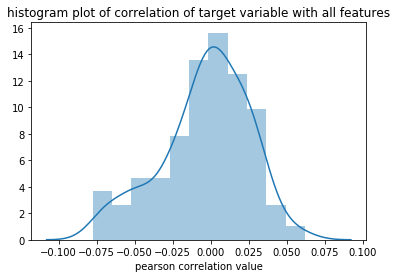

In [17]:
sns.distplot(features.corr()['gold_target'].values[:-1],)
plt.title("histogram plot of correlation of target variable with all features")
plt.xlabel("pearson correlation value")

# Model Training and Evaluation

For training the prediction model we need to split the dataset to training and validation sets. It is good practice to do cross-validations, however since our problem is time-series forecasting and we are more interested in predicting the most recent data, we can use hold-out validation where we consider the data before Jan 2018 for training and the data after that for validation and testing.

In [18]:
X_train = features[features['date'] < '2018-01-01'][features.columns[:-1]]
X_test = features[features['date'] >= '2018-01-01'][features.columns[:-1]]
y_train = features[features['date'] < '2018-01-01']['gold_target']
y_test = features[features['date'] >= '2018-01-01']['gold_target']

In [19]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2547, 152) (2547,)
(930, 152) (930,)


### Ordering features wrt correlation with Gold price

Now that we have the set of features at hand lets order them in order of their correlation to the target variable. Since we are using a greedy approach for feature selection, the goal here is that we avoid adding a less important feature in the first steps, while in the future a more important feature may be discarded because of some correlation with lesser important feature.

In [20]:
corr_sorted = sorted_correlations_with_gold(values.corr())
feature_columns = X_train.columns[1:].values
feature_columns_sorted = []


# add short term features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 't-' in x)])
# add long term features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 'months' in x)])
    
# add moving avg features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and (('SMA' in x) or ('EMA' in x)))])
len(feature_columns_sorted)

    
# add roc ratio features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 'rocr' in x)])

# add osc features
for val in corr_sorted.index:
    feature_columns_sorted.extend([x for x in feature_columns if (val in x and 'osc' in x)])
    


In [21]:
assert len(feature_columns_sorted) == len(features.columns)-2

## Feature Selection 

For the model choice we are considering a linear model e.g. **Linear Regression** and a non-linear model e.g. **gradient boosting trees (XGBoost)** as candidates. We would like to see which model would be able to minimize the loss and bias and variance errors on the validation set.

### Holdout Validation [Linear Regression]

In the first step we do not discard any feature from the model. We add the features one by one and train the model on those features and capture the training and validation losses. Note that for linear regression we are using r2 score as the evaluation metric.

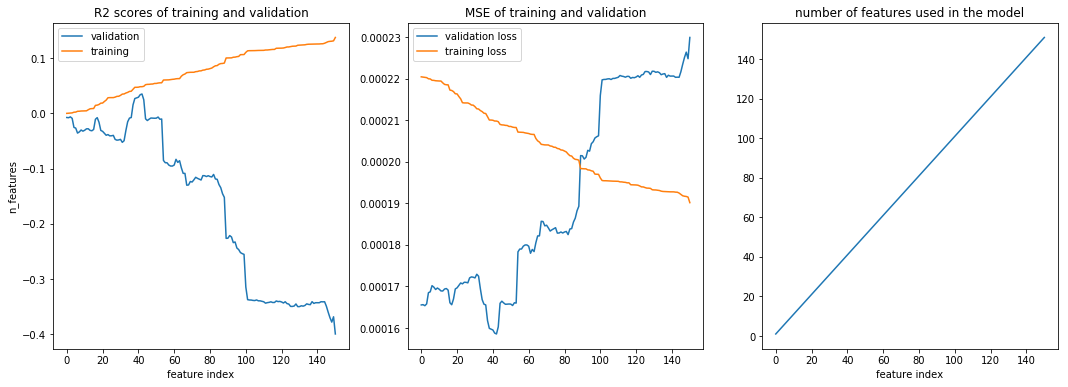

In [51]:
used_features = []
max_score = -np.inf
validation_scores, training_scores, n_features_used = [],[],[]
validation_loss, training_loss = [],[]
for f in feature_columns_sorted:
    used_features.append(f)
    lr = LinearRegression()
    model = lr.fit(X=X_train[used_features],y=y_train.values)
    y_pred = model.predict(X_test[used_features])
    score = lr.score(X_test[used_features],y_test)
    validation_scores.append(score)
    validation_loss.append(mean_squared_error(y_test,y_pred))
    y_pred_train = model.predict(X_train[used_features])
    score_train = lr.score(X_train[used_features],y_train)
    training_scores.append(score_train)
    training_loss.append(mean_squared_error(y_train,y_pred_train))
    if score > max_score:
        max_score = score

    n_features_used.append(len(used_features))
create_lr_plot(validation_scores,training_scores,validation_loss,training_loss,n_features_used)

As more features are added to the linear regression model we see that the training loss keeps decreasing while the validation loss keeps increasing. This is expected as we are not discarding any feature, so overfitting occurs as more features are added to the model

This time let's add each feature one by one and monitor the score on validation set. We only keep the feature if it
improves the score, otherwise the feature is discarded.

In [52]:
useful_features = []
max_score = -np.inf
validation_scores, training_scores, n_features_used = [],[],[]
validation_loss, training_loss = [],[]
for f in feature_columns_sorted:
    print("adding feature %s"%f)
    useful_features.append(f)
    lr = LinearRegression()
    model = lr.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = lr.score(X_test[useful_features],y_test)
    validation_scores.append(score)
    validation_loss.append(mean_squared_error(y_test,y_pred))
    y_pred_train = model.predict(X_train[useful_features])
    score_train = lr.score(X_train[useful_features],y_train)
    training_scores.append(score_train)
    training_loss.append(mean_squared_error(y_train,y_pred_train))
    if score > max_score:
        print("r2 score increased")
        max_score = score
    else:
        print('r2 score did not increase. removing feature %s'%f)
        useful_features.remove(f)
    print("validation score: %.5f"%score, end="\t")
    print("training score: %.5f"%score_train,end="\t")
    print("max score: %.5f"%max_score)
    n_features_used.append(len(useful_features))
    print('-'*80)

adding feature Gold_t-1
r2 score increased
validation score: -0.00738	training score: 0.00010	max score: -0.00738
--------------------------------------------------------------------------------
adding feature Gold_t-2
r2 score did not increase. removing feature Gold_t-2
validation score: -0.00778	training score: 0.00041	max score: -0.00738
--------------------------------------------------------------------------------
adding feature Gold_t-3
r2 score increased
validation score: -0.00626	training score: 0.00074	max score: -0.00626
--------------------------------------------------------------------------------
adding feature Gold_t-5
r2 score did not increase. removing feature Gold_t-5
validation score: -0.00893	training score: 0.00095	max score: -0.00626
--------------------------------------------------------------------------------
adding feature Gold_t-7
r2 score did not increase. removing feature Gold_t-7
validation score: -0.02241	training score: 0.00199	max score: -0.00626
----

r2 score increased
validation score: 0.08678	training score: 0.01831	max score: 0.08678
--------------------------------------------------------------------------------
adding feature Platinum_t-5
r2 score did not increase. removing feature Platinum_t-5
validation score: 0.07300	training score: 0.01940	max score: 0.08678
--------------------------------------------------------------------------------
adding feature Platinum_t-7
r2 score did not increase. removing feature Platinum_t-7
validation score: 0.02041	training score: 0.02598	max score: 0.08678
--------------------------------------------------------------------------------
adding feature Platinum_t-14
r2 score did not increase. removing feature Platinum_t-14
validation score: 0.06872	training score: 0.02067	max score: 0.08678
--------------------------------------------------------------------------------
adding feature Platinum_t-21
r2 score did not increase. removing feature Platinum_t-21
validation score: 0.08516	training sc

r2 score did not increase. removing feature Copper_2months
validation score: 0.11314	training score: 0.02842	max score: 0.11468
--------------------------------------------------------------------------------
adding feature Copper_3months
r2 score increased
validation score: 0.11629	training score: 0.02938	max score: 0.11629
--------------------------------------------------------------------------------
adding feature Copper_6months
r2 score did not increase. removing feature Copper_6months
validation score: 0.11585	training score: 0.02946	max score: 0.11629
--------------------------------------------------------------------------------
adding feature Euronext100_2months
r2 score did not increase. removing feature Euronext100_2months
validation score: 0.11593	training score: 0.02939	max score: 0.11629
--------------------------------------------------------------------------------
adding feature Euronext100_3months
r2 score did not increase. removing feature Euronext100_3months
valid

r2 score increased
validation score: 0.12930	training score: 0.03273	max score: 0.12930
--------------------------------------------------------------------------------
adding feature Platinum_rocr_2
r2 score did not increase. removing feature Platinum_rocr_2
validation score: 0.12686	training score: 0.03317	max score: 0.12930
--------------------------------------------------------------------------------
adding feature Platinum_rocr_3
r2 score did not increase. removing feature Platinum_rocr_3
validation score: 0.12810	training score: 0.03323	max score: 0.12930
--------------------------------------------------------------------------------
adding feature Platinum_rocr_5
r2 score increased
validation score: 0.12959	training score: 0.03389	max score: 0.12959
--------------------------------------------------------------------------------
adding feature Platinum_rocr_7
r2 score did not increase. removing feature Platinum_rocr_7
validation score: 0.12808	training score: 0.03446	max scor

In [53]:
print("r2 score: %.3f" %lr.score(X_test[useful_features],y_test))
print("rmse: %.7f" %np.sqrt(mean_squared_error(y_test,y_pred)))

r2 score: 0.138
rmse: 0.0118993


After training on various number of features while discarding the low performing ones. we can see that around 50 features are used in the final model. However, as we are monitoring validation loss not to go up, we see that the training loss does not decrease as much. This shows that the model has high bias with this number of features and is not able to explain the variations in the training set even with higher number of features.

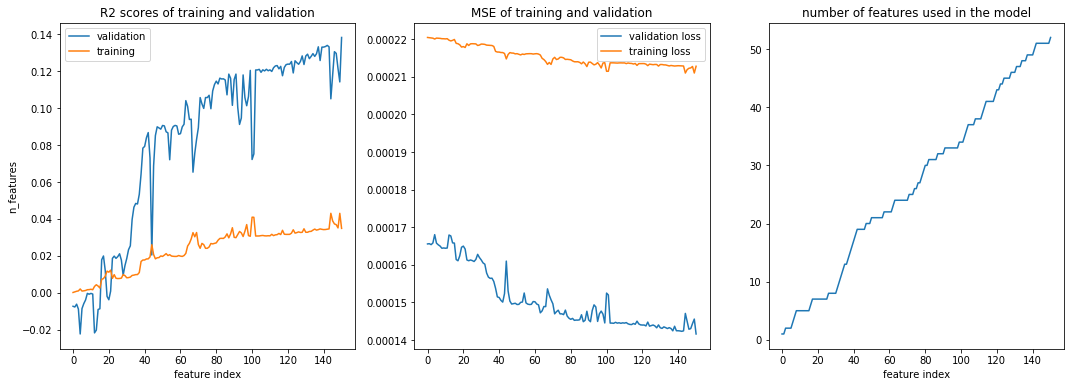

In [54]:
create_lr_plot(validation_scores,training_scores,validation_loss,training_loss,n_features_used)

## Feature Selection [XGBoost]

### Holdout Validation [XGB]

Since the linear regression was not able to model the data well, we shift our focus to XGBoost model as a non-linear model. XGBoost is a gradient boosting decision tree which has high performance. Similar to the linear regression approach, first we add all the features to the model without discarding them to see how training and validation losses would change. Unlike linear regression model we use mean squared error as the metric since squared error loss is the objective function for xgboost model.

final score: 0.00019


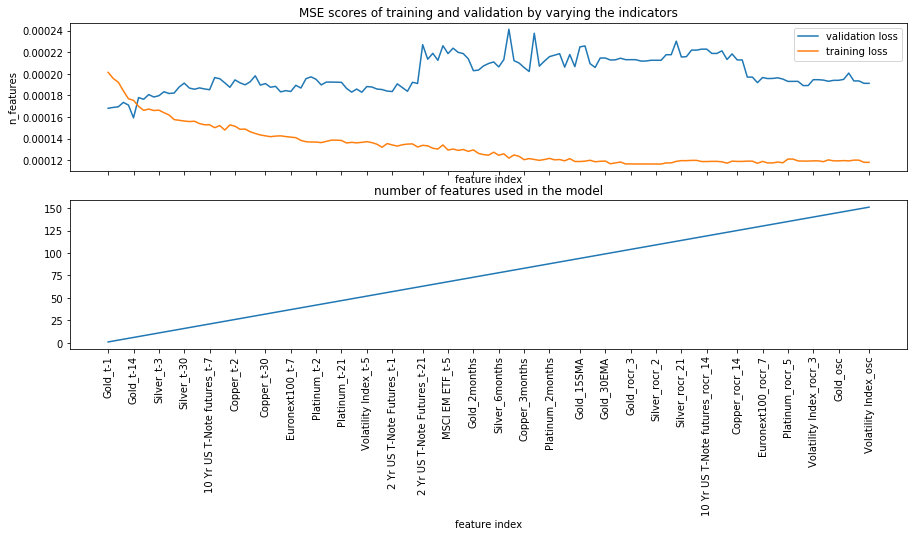

In [55]:
# running this cell may take a while as sequential models with cumulative number of features are added

used_features = []
min_score = np.inf
validation_scores, training_scores, n_features_used = [],[],[]
for f in feature_columns_sorted:
    used_features.append(f)
    xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
    model = xg.fit(X=X_train[used_features],y=y_train.values)
    y_pred = model.predict(X_test[used_features])
    score = mean_squared_error(y_test,y_pred)
    validation_scores.append(score)
    y_pred_train = model.predict(X_train[used_features])
    score_train = mean_squared_error(y_train,y_pred_train)
    training_scores.append(score_train)
    if score < min_score:
        min_score = score
    n_features_used.append(len(used_features))
    
xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
score = mean_squared_error(y_test,y_pred)
print("final score: %.5f"%score)
create_xgb_plot(validation_scores,training_scores,n_features_used,feature_columns_sorted)

Again we see that as the number of features are increased the training loss decreases and validation loss increases which shows overfitting pattern. We need to go through he features again one by one and select the features that decrease the loss.

This time let's add each feature one by one and monitor the score on validation set. We only keep the feature if its improves the score, otherwise the feature is discarded.

In [56]:
useful_features = []
min_score = np.inf
validation_scores, training_scores, n_features_used = [],[],[]
for f in feature_columns_sorted:
    print("adding feature %s"%f)
    useful_features.append(f)
    xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    validation_scores.append(score)
    y_pred_train = model.predict(X_train[useful_features])
    score_train = mean_squared_error(y_train,y_pred_train)
    training_scores.append(score_train)
    if score < min_score:
        print("mse loss decreased. score: %.8f" %score)
        min_score = score
    else:
        print('mse loss did not decrease. removing feature')
        useful_features.remove(f)
    print("validation loss: %.8f"%score, end="\t")
    print("training loss: %.8f"%score_train, end="\t")
    print("min loss: %.8f"%min_score)
    n_features_used.append(len(useful_features))
    print('-'*80)
    
xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
score = mean_squared_error(y_test,y_pred)
print("final score: %.5f"%score)

adding feature Gold_t-1
mse loss decreased. score: 0.00016804
validation loss: 0.00016804	training loss: 0.00020139	min loss: 0.00016804
--------------------------------------------------------------------------------
adding feature Gold_t-2
mse loss did not decrease. removing feature
validation loss: 0.00016885	training loss: 0.00019572	min loss: 0.00016804
--------------------------------------------------------------------------------
adding feature Gold_t-3
mse loss did not decrease. removing feature
validation loss: 0.00016987	training loss: 0.00019455	min loss: 0.00016804
--------------------------------------------------------------------------------
adding feature Gold_t-5
mse loss did not decrease. removing feature
validation loss: 0.00017502	training loss: 0.00019043	min loss: 0.00016804
--------------------------------------------------------------------------------
adding feature Gold_t-7
mse loss decreased. score: 0.00016654
validation loss: 0.00016654	training loss: 0.000

mse loss did not decrease. removing feature
validation loss: 0.00016364	training loss: 0.00016301	min loss: 0.00014834
--------------------------------------------------------------------------------
adding feature Euronext100_t-21
mse loss did not decrease. removing feature
validation loss: 0.00015257	training loss: 0.00016557	min loss: 0.00014834
--------------------------------------------------------------------------------
adding feature Euronext100_t-30
mse loss did not decrease. removing feature
validation loss: 0.00017671	training loss: 0.00016577	min loss: 0.00014834
--------------------------------------------------------------------------------
adding feature Platinum_t-1
mse loss did not decrease. removing feature
validation loss: 0.00014848	training loss: 0.00016820	min loss: 0.00014834
--------------------------------------------------------------------------------
adding feature Platinum_t-2
mse loss decreased. score: 0.00014637
validation loss: 0.00014637	training loss:

mse loss did not decrease. removing feature
validation loss: 0.00016015	training loss: 0.00015701	min loss: 0.00014604
--------------------------------------------------------------------------------
adding feature Silver_2months
mse loss did not decrease. removing feature
validation loss: 0.00015137	training loss: 0.00016386	min loss: 0.00014604
--------------------------------------------------------------------------------
adding feature Silver_3months
mse loss did not decrease. removing feature
validation loss: 0.00014855	training loss: 0.00016280	min loss: 0.00014604
--------------------------------------------------------------------------------
adding feature Silver_6months
mse loss did not decrease. removing feature
validation loss: 0.00015652	training loss: 0.00016460	min loss: 0.00014604
--------------------------------------------------------------------------------
adding feature 10 Yr US T-Note futures_2months
mse loss did not decrease. removing feature
validation loss: 0.

mse loss did not decrease. removing feature
validation loss: 0.00014873	training loss: 0.00016800	min loss: 0.00014497
--------------------------------------------------------------------------------
adding feature Silver_rocr_7
mse loss did not decrease. removing feature
validation loss: 0.00015011	training loss: 0.00016643	min loss: 0.00014497
--------------------------------------------------------------------------------
adding feature Silver_rocr_14
mse loss did not decrease. removing feature
validation loss: 0.00014712	training loss: 0.00016652	min loss: 0.00014497
--------------------------------------------------------------------------------
adding feature Silver_rocr_21
mse loss did not decrease. removing feature
validation loss: 0.00015251	training loss: 0.00016531	min loss: 0.00014497
--------------------------------------------------------------------------------
adding feature 10 Yr US T-Note futures_rocr_2
mse loss did not decrease. removing feature
validation loss: 0.00

mse loss did not decrease. removing feature
validation loss: 0.00015147	training loss: 0.00016504	min loss: 0.00014478
--------------------------------------------------------------------------------
adding feature Copper_osc
mse loss did not decrease. removing feature
validation loss: 0.00015124	training loss: 0.00016611	min loss: 0.00014478
--------------------------------------------------------------------------------
adding feature Euronext100_osc
mse loss did not decrease. removing feature
validation loss: 0.00014667	training loss: 0.00016685	min loss: 0.00014478
--------------------------------------------------------------------------------
adding feature Platinum_osc
mse loss did not decrease. removing feature
validation loss: 0.00014669	training loss: 0.00016873	min loss: 0.00014478
--------------------------------------------------------------------------------
adding feature Volatility Index_osc
mse loss did not decrease. removing feature
validation loss: 0.00014612	trainin

In [57]:
print("mean squared error: %.8f" %min_score)
print("root mean squared error: %.8f" %np.sqrt(min_score))

mean squared error: 0.00014478
root mean squared error: 0.01203257


Using Xgboost model we se that around 13 features are added to the model in total. Also both training and validation loss show decreasing patterns and the loss values is lower than the linear regression model one. Therefore, we select these features as our final set of features for model training purpose.

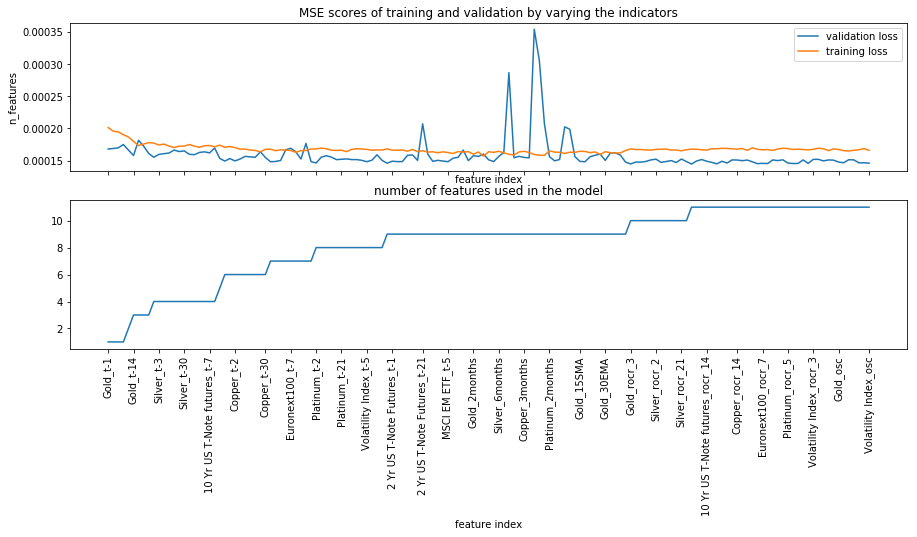

In [58]:
create_xgb_plot(validation_scores,training_scores,n_features_used,feature_columns_sorted)

Here we are visializing the target variable groundtruth and model prediction on the validation set

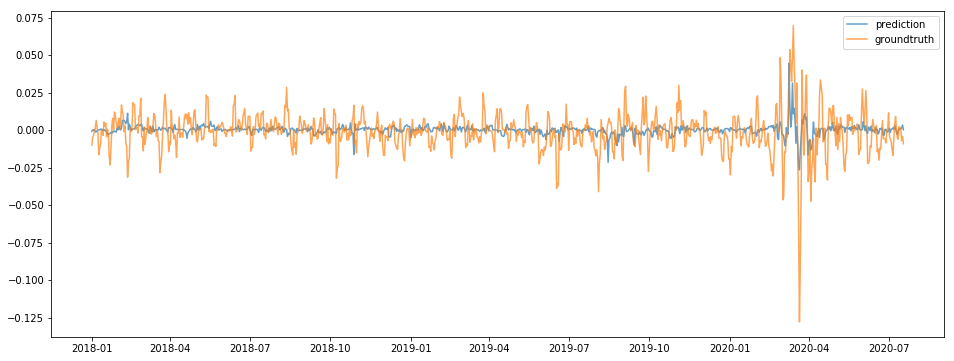

In [59]:

plt.figure(figsize=(16,6))
plt.plot(X_test['date'],y_pred, label='prediction',alpha=0.7)
plt.plot(X_test['date'],y_test.values, label='groundtruth',alpha=0.7)
plt.legend()

In [60]:
df_predict = pd.DataFrame()
df_predict['date'] = X_test['date']
df_predict['return_prediction'] = y_pred


In [61]:
results = pd.DataFrame()
results['date']  = pd.date_range(start='2018-01-01', end= values['date'].iloc[-1])
results = pd.merge(left=results, right=values[['date','Gold']], on='date', how='left')
results = pd.merge(left=results, right=df_predict[['date','return_prediction']], on='date', how='left')
results ['predicted_price'] = results['Gold']*(results ['return_prediction']+1)
results ['predicted_price'] = results ['predicted_price'].shift(n_days_ahead)
results.tail(10)

date    Gold  return_prediction  predicted_price
923 2020-07-12  1804.1          -0.000215      1822.357529
924 2020-07-13  1801.9           0.000898      1800.994615
925 2020-07-14  1812.9           0.000568      1798.880120
926 2020-07-15  1815.0           0.001297      1803.711377
927 2020-07-16  1797.8           0.001548      1803.518757
928 2020-07-17  1812.1           0.003447      1813.930002
929 2020-07-18  1812.1           0.000263      1817.353401
930 2020-07-19  1810.5                NaN      1800.583516
931 2020-07-20  1819.6                NaN      1818.345762
932 2020-07-21  1828.6                NaN      1812.577186

Let's visualize gold price prediction vs groundtruth based on the predicted returns

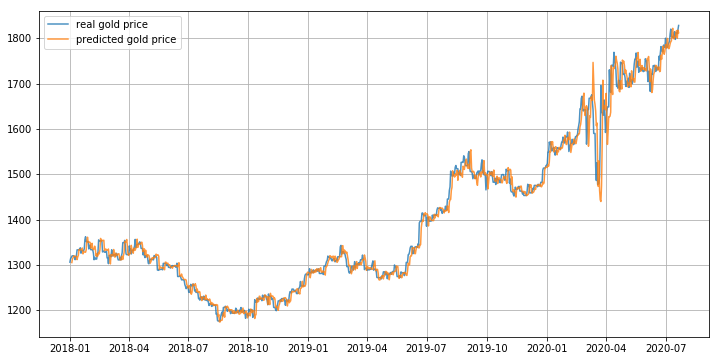

In [62]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['Gold'], label="real gold price",alpha=0.8)
plt.plot(results['date'], results['predicted_price'], label="predicted gold price",alpha=0.8)
plt.grid()
plt.legend()

## Feature importance

By observing feature importance list we can see that the majority of helpful features are from short-term lags. In addition we see that ratio of ROC (rocr) for some of the indexes are helpful as well.

In [63]:
pd.DataFrame({"feature":useful_features,"importance":xg.feature_importances_})

feature  importance
0                         Gold_t-1    0.072293
1                         Gold_t-7    0.085256
2                        Gold_t-14    0.100516
3                       Silver_t-2    0.091824
4     10 Yr US T-Note futures_t-21    0.144705
5     10 Yr US T-Note futures_t-30    0.088996
6                  Euronext100_t-1    0.094935
7                     Platinum_t-2    0.066384
8            Volatility Index_t-30    0.093618
9                      Gold_rocr_3    0.082856
10  10 Yr US T-Note futures_rocr_3    0.078617

# Hyperparamter Tuning

In [64]:
xg = xgb.XGBRegressor(max_depth=3,objective='reg:squarederror')
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
score = mean_squared_error(y_test,y_pred)
err = mean_squared_error(y_test,y_pred)
print("validation score: %.5f"%score)
print("rmse: %.5f"%np.sqrt(err))

validation score: 0.00014
rmse: 0.01203


In [65]:
dtrain = xgb.DMatrix(X_train[useful_features], label=y_train.values)
dtest = xgb.DMatrix(X_test[useful_features], label=y_test.values)

In [67]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
}

In [68]:
params['eval_metric'] = "rmse"

### Tuning max-depth and min-child-weight

In [69]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,7)
    for min_child_weight in range(1,8)
]

min_score = np.inf
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    xg = xgb.XGBRegressor(**params)
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    print("validation score: %.8f"%score)
    
    if score < min_score:
        min_score = score
        print("****max score**** :%.8f"%max_score)
        best_params = params.copy()
        print("best params:", best_params)
params = best_params.copy()
print("min_loss: %.8f" %min_score)

max_depth=3, min_child_weight=1
validation score: 0.00014478
****max score**** :0.13835153
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 1, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse'}
max_depth=3, min_child_weight=2
validation score: 0.00014905
max_depth=3, min_child_weight=3
validation score: 0.00014911
max_depth=3, min_child_weight=4
validation score: 0.00015447
max_depth=3, min_child_weight=5
validation score: 0.00015411
max_depth=3, min_child_weight=6
validation score: 0.00015900
max_depth=3, min_child_weight=7
validation score: 0.00015732
max_depth=4, min_child_weight=1
validation score: 0.00014965
max_depth=4, min_child_weight=2
validation score: 0.00015298
max_depth=4, min_child_weight=3
validation score: 0.00015252
max_depth=4, min_child_weight=4
validation score: 0.00015778
max_depth=4, min_child_weight=5
validation score: 0.00015390
max_depth=4, min_child_weight=6
validation score: 0.00016129
max_depth=4, min_

### Tuning subsample and colsample

In [70]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_score = np.inf
best_params = None
for subsample, colsample in gridsearch_params:
    print("subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    params['subsample'] = subsample
    params['colsample'] = colsample
    xg = xgb.XGBRegressor(**params)
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    err = mean_squared_error(y_test,y_pred)
    print("validation score: %.8f"%score)
    print("rmse: %.5f"%np.sqrt(err))
    
    if score < min_score:
        min_score = score
        print("****min score**** :%.8f"%max_score)
        best_params = params.copy()
        print("best params:", best_params)
params = best_params.copy()   
print("min_loss: %.8f" %min_score)

subsample=0.7, colsample=0.7
validation score: 0.00015835
rmse: 0.01258
****min score**** :0.13835153
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 0.7, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'colsample': 0.7}
subsample=0.7, colsample=0.8
validation score: 0.00015835
rmse: 0.01258
subsample=0.7, colsample=0.9
validation score: 0.00015835
rmse: 0.01258
subsample=0.7, colsample=1.0
validation score: 0.00015835
rmse: 0.01258
subsample=0.8, colsample=0.7
validation score: 0.00015052
rmse: 0.01227
****min score**** :0.13835153
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 0.8, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'colsample': 0.7}
subsample=0.8, colsample=0.8
validation score: 0.00015052
rmse: 0.01227
subsample=0.8, colsample=0.9
validation score: 0.00015052
rmse: 0.01227
subsample=0.8, colsample=1.0
validation score: 0.00015052
rmse: 0.01227
subs

### Tuning eta

In [71]:
min_score = np.inf
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("eta={}".format(eta))
    params['eta'] = eta
    xg = xgb.XGBRegressor(**params)
    model = xg.fit(X=X_train[useful_features],y=y_train.values)
    y_pred = model.predict(X_test[useful_features])
    score = mean_squared_error(y_test,y_pred)
    #err = mean_squared_error(y_test,y_pred)
    print("validation score: %.5f"%score)
    #print("rmse: %.5f"%np.sqrt(err))
    
    if score < min_score:
        min_score = score
        print("****min score**** :%.5f"%max_score)
        best_params = params.copy()
        print("best params:", best_params)
params = best_params.copy()  
print("min_loss: %.8f" %min_score)

eta=0.3
validation score: 0.00014
****min score**** :0.13835
best params: {'max_depth': 3, 'min_child_weight': 1, 'eta': 0.3, 'subsample': 1.0, 'colsample_bytree': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'colsample': 0.7}
eta=0.2
validation score: 0.00014
eta=0.1
validation score: 0.00014
eta=0.05
validation score: 0.00014
eta=0.01
validation score: 0.00014
eta=0.005
validation score: 0.00014
min_loss: 0.00014478


In [72]:
params

{'max_depth': 3,
 'min_child_weight': 1,
 'eta': 0.3,
 'subsample': 1.0,
 'colsample_bytree': 1,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'colsample': 0.7}

### Final metrics after fine-tuning

In [73]:
xg = xgb.XGBRegressor(**params)
model = xg.fit(X=X_train[useful_features],y=y_train.values)
y_pred = model.predict(X_test[useful_features])
valid_loss = mean_squared_error(y_test,y_pred)
train_loss = mean_squared_error(y_train,y_pred_train)
print("validation loss: %.5f"%valid_loss)
print("validation rmse: %.5f"%np.sqrt(valid_loss))
print("validatio r2 score: %.5f"% r2_score(y_test,y_pred))



validation loss: 0.00014
validation rmse: 0.01203
validatio r2 score: 0.11894


### Save Model

Now that we have trained and fine-tuned the model, let's train the model with the selected hyperparameters and using the whole dataset as training set, to make use of all the data available for better forecasting. Finally we save the model, so that it can later be used for inference.

In [74]:
X = features[features.columns[:-1]]
y = features['gold_target']

xg = xgb.XGBRegressor(**params)
model = xg.fit(X=X[useful_features],y=y.values)
# save model
pickle.dump(model, open("model/gold_price.pickle.dat", "wb"))

# save features
with open('model/features.txt', 'w') as f:
    for feat in useful_features:
        f.write('%s\n' % feat)